# ADA Project - DataBrewers

Beer reviews offer a unique lens into consumer preferences, revealing intriguing patterns influenced by both seasonal trends and long-term shifts in population taste. The goal of our project is to analyze potential patterns in consumers’ ratings and reviews over time, focusing on how beer preferences evolve across seasons and years. This research could provide valuable insights for professionals such as brewers and marketers, enabling them to better align their product offerings with consumer demand. By understanding these seasonal trends, brewers can optimize their strategies to adapt to shifting preferences.

## Table of Contents


- ADA Project - DataBrewers
  - Table of content
  - Data pre-processing
    - Loading the data
    - Importation of the scripts
  - Seasonal trend analysis
    - Seasonal influence on beer ratings for low and high ABV beers
    - Seasonal trend in beer ratings at the scales of the US
    - Seasonal trend in beer ratings across the states
  - Sentiment analysis
  - Semantic analysis
    - Reviews exploration
    - Flavor analysis
    - Semantic analysis by seasons
      - Aroma preferences
      - Mouthfeel preferences
      - Palate preferences
    - Wordcloud by seasons




## Data pre-processing 


In [1]:
import pandas as pd
import tarfile
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import re
import wordcloud
import nltk
import sys
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import geopandas as gpd


import plotly.io as pio
pio.renderers.default = "browser"
import plotly.express as px

In [2]:
# Run the preprocessing script
# %run src/scripts/preprocessing.py

#### Loading the data

In [3]:
reviews = pd.read_csv('data/cleaned/reviews.csv.gz', compression='gzip')
ratings = pd.read_csv('data/cleaned/ratings.csv.gz', compression='gzip')
users = pd.read_csv('data/cleaned/users.csv.gz', compression='gzip')
beers_ba = pd.read_csv('data/cleaned/beers.csv.gz', compression='gzip')
breweries_ba = pd.read_csv('data/cleaned/breweries.csv.gz', compression='gzip')

#### Importation of the scripts

In [4]:
import sys
sys.path.append('src')

import scripts.categorization as categ
import scripts.plot as plot
import scripts.statistics as stats
import scripts.sentiment_analysis as sent_ana
import scripts.semantic_analysis as sem_ana



## Seasonal trend analysis


To understand the seasonal analysis, it is important to understand how the beers are rated. In both reviews and ratings dataframes, 6 columns contain metrics ( which are a score out of 5): **appearance, aroma, taste, mouthfeel, overall and rating**. The rating metrics is computed based on the 5 other scores with the following formula:
$$
\text{Rating} = 0.06 \cdot \text{Appearance} + 0.24 \cdot \text{Aroma} + 0.4 \cdot \text{Taste} + 0.1 \cdot \text{Mouthfeel} + 0.2 \cdot \text{Overall}
$$

 We focus only on the "rating" metric out of the five others, as similar trends were observed across all of them, and the "rating" metric is derived from the other five scores. A detailed analysis of the individual metrics can be found in the notebook `seasonal_trend_analysis.ipynb`.

In [5]:
# Order the seasons
ratings_top_styles = categ.order_season(ratings)

### Seasonal influence on beer ratings for low and high ABV beers
Beers are also characterized by their **Alcohol By Volume (ABV)**, which was categorized into three groups during the preprocessing and cleaning phase: **low, middle, and high**. We are interested to see whether the ratings of low ABV or high ABV beers are influenced by seasonal changes throughout the year.

In [6]:
mean_ratings = ratings.groupby(['season', 'abv_category'], as_index=False, observed=False)['rating'].mean()

# Separate data for high and low alcohol content
high_abv = mean_ratings[mean_ratings['abv_category'] == 'high']
low_abv = mean_ratings[mean_ratings['abv_category'] == 'low']

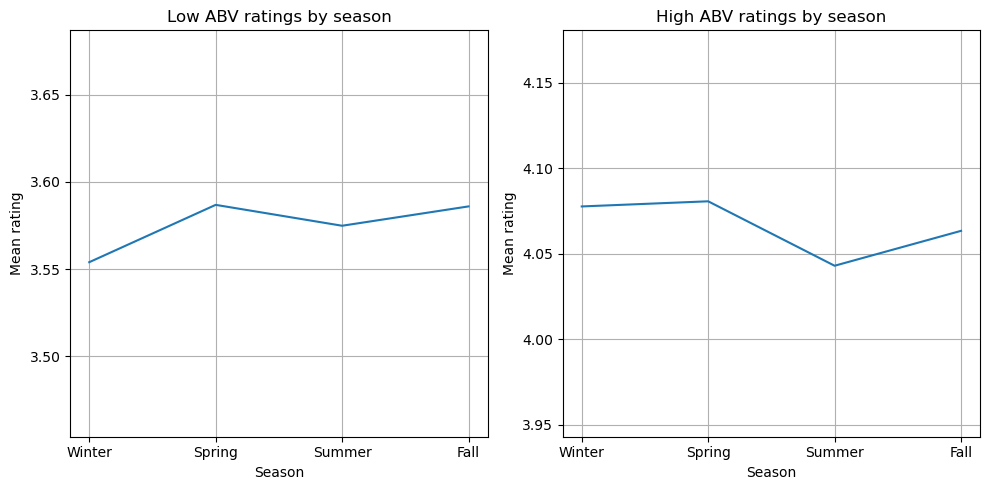

In [7]:
plot.plot_high_low_abv_trends(high_abv, low_abv)

In [8]:
stats.test_seasonal_significance_ABV(ratings, 'low')

Number of ratings per season for 'low' ABV:
season
Summer    375426
Spring    317016
Fall      297901
Winter    289889
Name: count, dtype: int64
ANOVA Result: F-statistic = 144.5897, p-value = 0.0000
Significant differences detected among seasons. Performing pairwise Tukey HSD test...

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
  Fall Spring   0.0009 0.959 -0.0037  0.0054  False
  Fall Summer  -0.0111   0.0 -0.0154 -0.0067   True
  Fall Winter   -0.032   0.0 -0.0366 -0.0273   True
Spring Summer   -0.012   0.0 -0.0163 -0.0077   True
Spring Winter  -0.0328   0.0 -0.0374 -0.0283   True
Summer Winter  -0.0209   0.0 -0.0253 -0.0165   True
---------------------------------------------------


In [9]:
stats.test_seasonal_significance_ABV(ratings, 'high')

Number of ratings per season for 'high' ABV:
season
Winter    558904
Spring    527384
Summer    484628
Fall      464016
Name: count, dtype: int64
ANOVA Result: F-statistic = 484.3607, p-value = 0.0000
Significant differences detected among seasons. Performing pairwise Tukey HSD test...

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  Fall Spring   0.0173    0.0  0.0144  0.0201   True
  Fall Summer  -0.0204    0.0 -0.0233 -0.0175   True
  Fall Winter   0.0143    0.0  0.0114  0.0171   True
Spring Summer  -0.0377    0.0 -0.0405 -0.0349   True
Spring Winter   -0.003 0.0248 -0.0057 -0.0003   True
Summer Winter   0.0347    0.0  0.0319  0.0375   True
----------------------------------------------------


ANOVA and Turkey HSD tests revealed that all observed differences in rating between seasons are statistically significant, except for Fall vs. Spring in the low ABV category.

- **Low ABV beers**: These beers are rated highest in Spring, and lowest in Winter (~0.03 difference)

- **High ABV beers**: These beers receive the best ratings during Winter and the lowest in Summer (~0.04 difference)

### Seasonal trend in beer ratings at the scales of the US

From now, we will discuss the seasonal trends when looking at the most rated beers styles. The styles were simplified during preprocessing to regroup beers styles with similar characteristic, bringing the number of beer styles from 105 to 45. From these 45 simplified styles, we only kept the one than accounts for at least 2% of the ratings for the following analysis.

In [10]:
# Keep the most rated styles
ratings_top_styles = categ.top_styles(ratings)

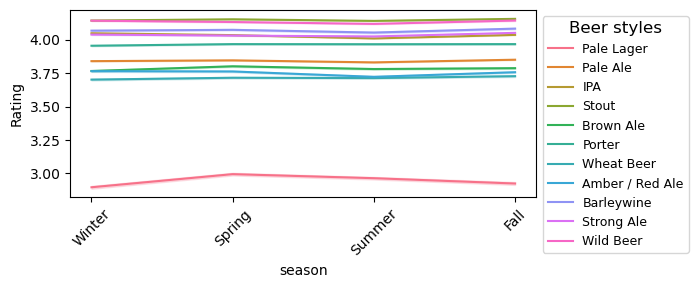

In [11]:
plot.plot(ratings_top_styles, 'season', 'rating', 'style_simp', 'Beer styles')

From the plot above, we can observe that the beers belonging to the **Pale Lager** style show visible variation between seasons, especially between winter and spring. For the other styles, the variability is not visible if it exists, especially in the rating score, which contains all other metrics.

In [12]:
anova_season_rating_style = stats.anova_test(ratings_top_styles, rating_column='rating', timescale='season', category='style_simp') 

style_simp: Pale Lager, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between season
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  Fall Spring   0.0701    0.0  0.0502    0.09   True
  Fall Summer   0.0399    0.0  0.0207  0.0591   True
  Fall Winter   -0.028 0.0019  -0.048  -0.008   True
Spring Summer  -0.0302 0.0001 -0.0487 -0.0118   True
Spring Winter  -0.0981    0.0 -0.1174 -0.0788   True
Summer Winter  -0.0679    0.0 -0.0864 -0.0493   True
----------------------------------------------------
--------------------------------------------------
style_simp: Pale Ale, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between season
Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  Fall Spring  -0.0048 0.0489 -0.0095    -0.0 

Analysis of beer ratings across seasons reveals notable seasonal differences for most styles, with some showing no significant differences due to small variations. We consider that even if the test is significant, the difference in between ratings must be at least of 0.01 to be considered a meaningful difference. All beer styles investigated have more than 100k ratings, we considered that from 0.01 the difference was meaningful enough. 

- **Higher ratings in warmer months (spring/summer)**:  
  - **Pale Lager** ratings are higher in spring and summer than in fall and winter, with spring ratings beating winter ratings by nearly 0.1 points and summer ratings outperforming fall ratings by 0.04 points. However, fall and winter ratings differ by only 0.03 points, suggesting minimal practical differences compared to the other variations of the style.
  - **Pale Ale** shows a preference for summer, with ratings 0.02 points higher than fall, while winter ratings are 0.01 points lower than fall. The differences between fall and spring are negligible, only 0.005 points.
  - The **IPA** ratings show a clear preference for summer, outperforming fall by 0.027 points and winter by 0.04 points. Conversely, fall and spring ratings show no significant difference (0.002 points). 
  - **Wild Beer** ratings favor summer, with ratings 0.025 points higher than fall, while winter ratings are nearly equal to fall (0.0011 point difference). 
  - **Amber/Red Ale** ratings are significantly higher in summer, exceeding fall by 0.0344 points and winter by 0.0425 points, while other seasonal differences are negligible.
  - For **Brown Ale**, ratings peak in the spring, outperforming the fall by 0.014 points and winter by 0.035 points. Summer and fall ratings are nearly equal, differing by only 0.006 points. 

- **Higher ratings in colder months (fall/winter)**:  
  - Ratings for **Wheat Beer** favor winter, with ratings 0.026 points higher than fall and 0.012 points lower than summer. There are no differences between spring and summer (0.002 points).
  - For **Barleywine**, winter ratings generally outperform both fall and summer, with winter ratings 0.015 points higher than fall and 0.014 points higher than summer. Summer ratings are the lowest, with a difference of 0.03 points compared to fall and 0.02 points compared to spring. Spring and winter do not show a significant difference.
  - **Stong Ale** receives its highest ratings in the fall, with the largest difference between the spring and summer months being 0.2 and 0.26 points, respectively. Winter ratings are also slightly lower than in the fall months, with a difference of 0.13 points. 

- **Consistent ratings across seasons**:  
  - For **Stouts**, winter ratings are slightly higher than fall and spring by 0.013 and 0.009 points, respectively, but no difference is observed between fall and spring or summer and winter. Since the difference is minimal, we consider it negligible.
  - **Porters** shows slightly higher ratings in winter, trailing fall by 0.012 points. The differences between fall, spring, and summer are negligible, all less than 0.01 points. Again, the difference is so small that we consider it negligible.

In summary, the following trends can be observed:

- **Warmer months**:  
  Lighter styles such as **Pale Lager**, **Pale Ale**, **IPA**, **Wild Beer**, **Amber/Red Ale**, **Brown Ale** and **Strong Ale** perform better in the spring and summer. These styles score higher in the warmer months, consistent with the preference for lighter, more refreshing beers during this time. **Pale Lager** and **IPA** show the most improvement in summer, while **Amber/Red Ale** has the highest ratings in summer compared to other seasons. 

- **Colder months**:  
  Richer and heavier styles such as **Wheat Beer**, **Barleywine**, **Strong Ale** have higher ratings in winter and fall. These beers, known for their fuller body and warming qualities, are more popular in the colder months. **Barleywine** and **Wheat Beer** are especially popular in winter, while **Strong Ale** has its highest ratings in fall, outperforming both spring and summer.

- **Minimal or No Seasonal Variation**:  
  **Stouts** and **Porters** show very small differences across seasons. The differences are minimal and do not reach the threshold of practical significance, indicating that these styles have consistent appeal throughout the year regardless of season.

### Seasonal trend in beer ratings across the states

We are now interested to see whether there we will observe other significant difference in beer style preferences across seasons at the state level.

First, the states were divided into three different categories:
- **Northeast** (e.g. New-York)
- **South** (e.g. Texas)
- **West** (e.g. California)
- **Midwest** (e.g. Minnesota)

We first hypothesize that, since the four regions experience varying weather conditions throughout the seasons, this may impact their ratings. However, analysis conducted in the `seasonal_trend_analysis.ipynb` notebook shows that the trends in ratings for the regions individually were not significantly different from the overall trend for the United States, particularly for the low and high ABV categories, as shown below:

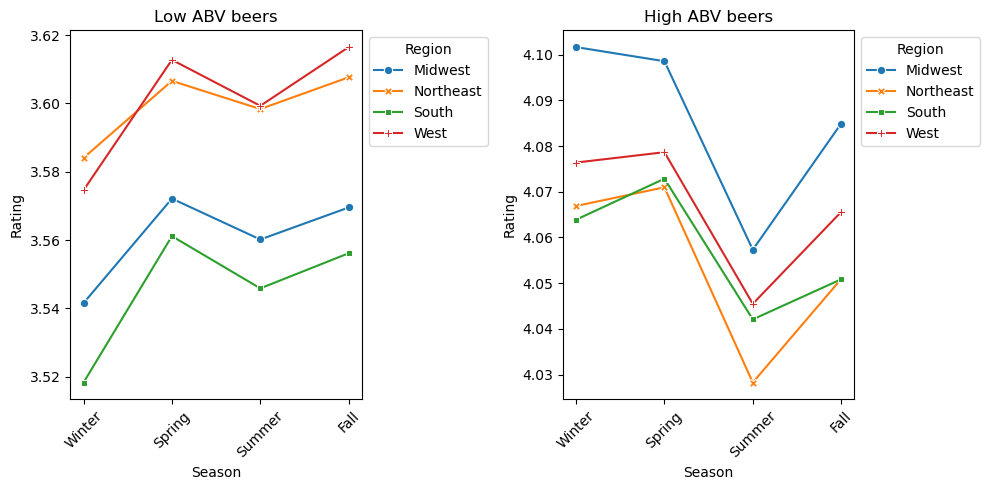

In [13]:
plot.plot_abv_seasonal_trends(ratings, "rating")

We are then interested in exploring the **preferred beer styles** across states and seasons. By doing so, we may be able to observe more pronounced changes and get more insights on how the season influences the appreciation of different beer styles. To get the preferred beer styles by season and state, we take the beer style that score the highest ratings on the "rating" metrics. 

In [14]:
# Strip the state names
ratings['states'] = ratings['states'].str.strip()

# Regroup reviews by states, season and style
state_season_style = (ratings.groupby(['states', 'season', 'style_simp'], observed=False)
                          .agg({'rating': 'mean'})
                          .reset_index())

# Keep only the highest rated style for each state-season
highest_rated_style = (
        state_season_style.loc[state_season_style.groupby(['states', 'season'], observed=False)['rating'].idxmax()]
        .reset_index(drop=True)
    )

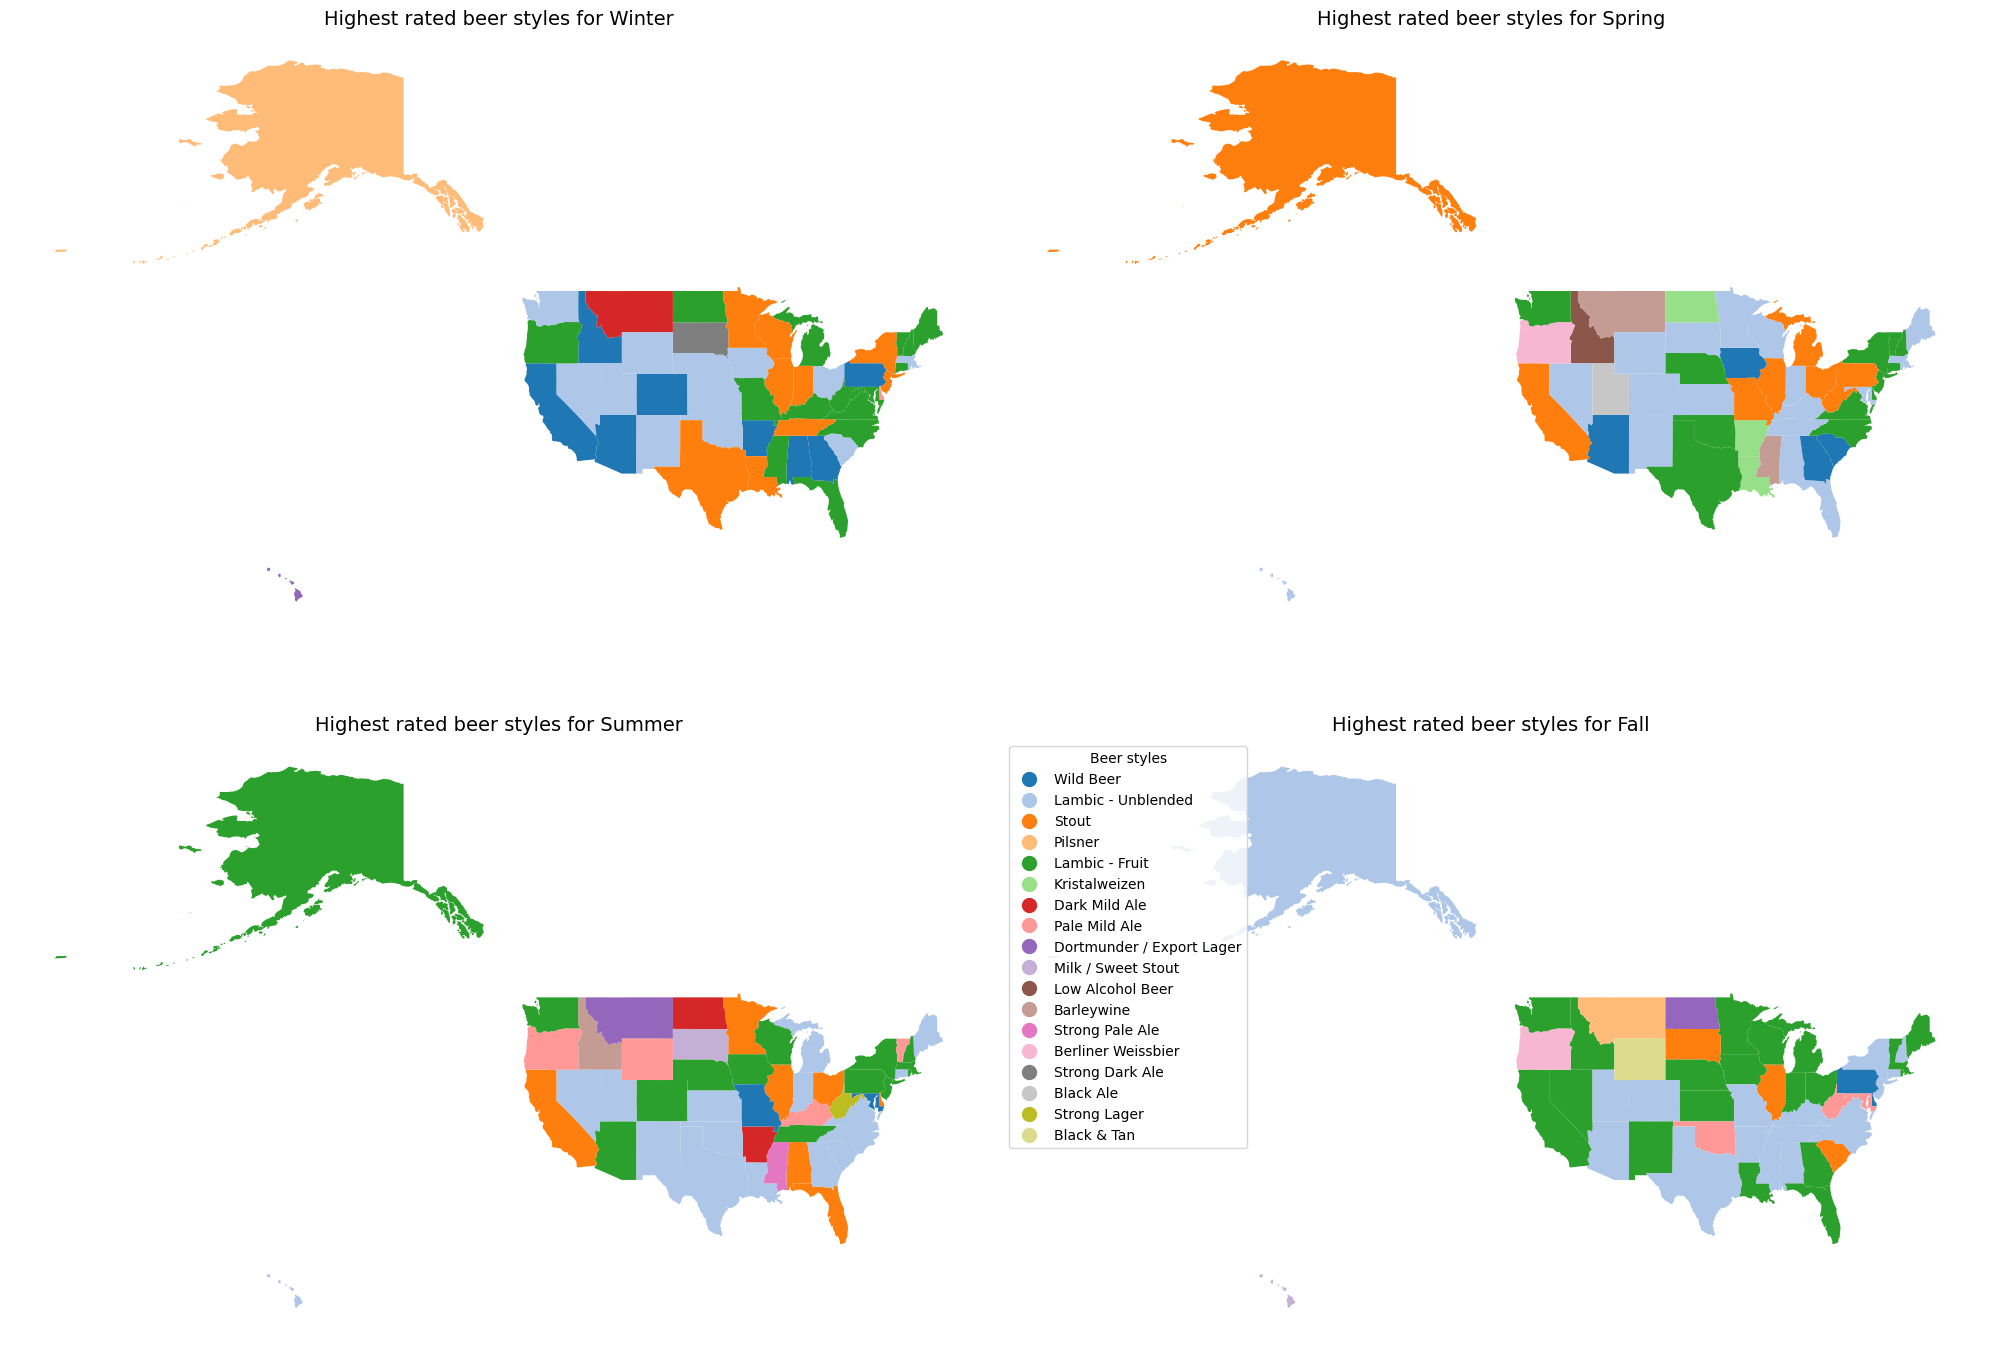

In [15]:
plot.plot_highest_rated_styles_by_season(highest_rated_style)

We can observe that the preferred beer styles are not the same in every state, and that they change with the seasons. If we divide the map of the USA in four regions (e.g. **West, South, Midwest, Northeast**), we get the following key observations:

- **Winter**: In the _West_, Wild beer and Lambic-Unblended are favored, while in Montana, Dark Mild Ale stands out. The _South_ prefers Stouts and Wild beer, while the _Midwest_ and _Northeast_ favor Dark Mild Ale and Stout, or Lambic-Fruit in the Northeast.

- **Spring**: The _West_ leans towards Pale Mild Ale, low alcohol beer and Lambic-Fruit. The _South_ and _Northeast_ also lean towards Lambic-Fruit, as well as Kristalweizen for the _South_. The _Midwest_ also appreciates Kristalweizen, and we can see a shift, notably from Stout to Lambic-Unblended. 

- **Summer**: The _West_ continues to favor Pale Mild Ale and Lambic-Fruit. The _South_ leans towards Lambic-Unblend, while the _Northeast_ stays consistent with Lambic-Fruit. The _Midwest_ prefers Lambic-Fruit and Milk/Sweet Stout. 

- **Fall**: The _West_ still appreciates Lambic-Fruit, but there is a move towards more Strong Pale Ale, particularly in Oregon. The _South_ still prefers Lambic-Unblended, while some states are moving towards Pale Mild Ale. The _Midwest_ remains consistent with Lambic-Fruit, while a certain preference for Stout is beginning to emerge. The _Northeast_ leans towards Lambic-Unblended and Wild beer. 

Thus, we can see that as the seasons transition from **warmer to colder**, there is a shift in preferences from **fruitier and lighter** beer styles (e.g. Lambic-Fruit, Pale Mild Ale) to **stronger** beer styles (e.g. Stout, Dark Mild Ale).



<a id="sentiment-analysis"></a>
## Sentiment analysis

In this section we look at the words used in the review to try to determine the ones that are associated to positive reviews and the ones associated to negative ones.

- We define that a beer is **positively graded** if the rating grade strictly bigger than 4/5.
- We define that a beer is **negatively graded** if the rating grade strictly less than 3/5.

This will allow use to determine the aspects of a beer that are **liked or disliked** by reviewers. This way we will be able to better understand the consumer preferences.

In [ ]:
# The sentiment analysis script are downloaded as sent_ana

# We download the stopwords to use them in the sentiment analysis
nltk.download('stopwords')

In [ ]:
# We begin by cleaning the reviews 
reviews_clean = sent_ana.clean_data(reviews)

# Separate the reviews into two groups: those with a rating higher than 4 and those with a rating lower than 3
reviews_high = reviews_clean[reviews_clean['rating'] > 4]
reviews_low = reviews_clean[reviews_clean['rating'] < 3]

# Tokenize the reviews
bigrams_high, bigrams_low = sent_ana.get_words(reviews_high, reviews_low)

# Count bigram frequencies for each group
bigram_freq_high = Counter(bigrams_high)
bigram_freq_low = Counter(bigrams_low)

To make it easier to visualize, we used Word Clouds. This way we can easily see the pair of words that are the most used, both for high and low ratings, and compare the potential differences between the two.

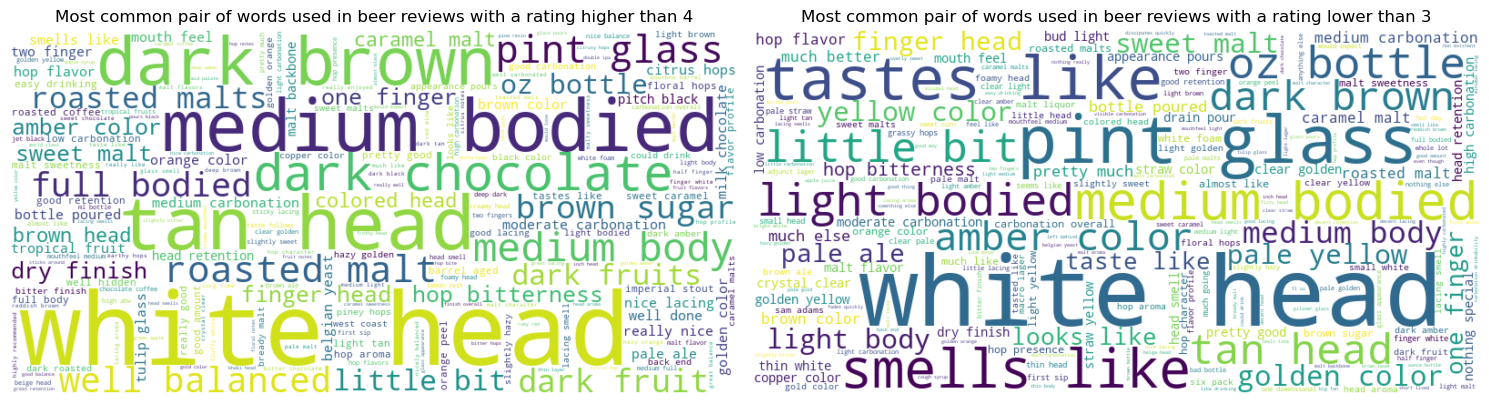

In [18]:
# Generate the word clouds
wordcloud_high = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_freq_high)
wordcloud_low = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(bigram_freq_low)

# We plot word clouds for both groups
sent_ana.plot_word_clouds(wordcloud_high, wordcloud_low)

Now that we know the pair of words that are the most used in reviews with **high ratings** (>4/5) and **low ratings** (<3/5), we can see that some pair of words seem specific to well rated beers, and some seem specific to poorly rated beers.

We further investigate this to extract pair of words used only positively and pair of words used only negatively. This will allow us to determine the user preferences and potentially what makes a beer enjoyable or not.

In [19]:
# We compare the most common bigrams in both groups
df_comparison = sent_ana.compare_high_low(bigram_freq_high, bigram_freq_low, reviews_high, reviews_low)

# We plot the comparison
print(df_comparison)

            Bigram  Percentage High Reviews  Percentage Low Reviews
28      white head                20.532803               23.064993
25        tan head                 9.291707                4.183089
15   medium bodied                 8.923919                5.115585
2       dark brown                 7.385701                3.972237
16     medium body                 6.685652                3.762025
20      pint glass                 6.139436                8.473848
8      full bodied                 5.657099                     NaN
27   well balanced                 5.595725                     NaN
3   dark chocolate                 5.502469                     NaN
21    roasted malt                 4.690034                     NaN
4       dark fruit                 4.294007                     NaN
1      brown sugar                 4.171487                     NaN
17       oz bottle                 4.057735                4.561856
13      little bit                 3.998410     

Now that we have the 20 most common pairs of words for both positive and negative reviews, as well as the percentage of reviews containing it, we can draw new conclusions. If a pair of words appear only in positive (resp. negative) reviews, and not in the negative (resp. positive) reviews, we can deduct that it is a rather positive (resp. negative) pair of words.

Some pair of words seem to be **neutral** as they appear in both positive and negative reviews. It could also simply mean that we need more context to understand whether they are associated to positive or negative feelings in the reviews. Among these, we can find the following pairs of words:
- white head 
- tan head
- medium bodied / medium body

There are also some pairs of words that are not really relevant to our analysis. For example the following pairs of words do not convey information on the caracteristics of a beer that reviewers like or dislike:
- pint glass
- oz bottle
- smells like / tastes like

However, we can also easily see that some pairs of words are used only in a positive or negative context.

We have that the following pairs of words only appear in **positive reviews**:
- full bodied
- dark chocolate 
- dark fruit / dark fruits
- roasted malts

While the following pairs of words only appear in **negative reviews**: 
- light bodied / light body
- amber color
- yellow color / pale yellow

This analysis highlights the fact that reviewers seem to prefer **full bodied** beers to **light bodied** ones. **Medium bodied** beers are cited in both positive and negative reviews.
Consumers also seem to appreciate specific flavors and aromes as **dark chocolate**, **dark fruits**.


<a id="semantic-analysis"></a>

## Semantic analysis

### Reviews exploration

In this section we aim to analyze the global semantic of the reviews and associate recurrent words to positive reviews. This will help us understand how different characteristics are associated with the beers' appeal. 
We will then perform this semantic analysis across seasons, to evaluate how consumer tastes and expectations vary depending on the time of the year.

In [20]:
clean_reviews = sem_ana.get_cleaned_reviews(reviews)

100%|██████████| 2048878/2048878 [01:09<00:00, 29625.17it/s]
/Users/eugeniecyrot/Documents/epfl/Master/MA3/ADA/ada-2024-project-databrewers/src/scripts/semantic_analysis.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Here we tokenise and clean the reviews so we can use them later

In [21]:
top_20_words,word_freq = sem_ana.top_n_words(clean_reviews, 20)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eugeniecyrot/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Processing: 100%|██████████| 253627098/253627098 [00:28<00:00, 8888480.07it/s]


Here simply count the frequency of words appearing in our reviews here again we select just a few

With juste a glance we can see a lot of words around the **taste** and the **aroma** we know we can direct our analysis on those.

### Flavor analysis 

We are analysing certain words associated with the description of flavours the following: hoppy, malty, fruity, spicy, citrus, sweet, bitter, sour, tart, crisp

Normalizing flavour occurrences by total flavour mentions per month...
Flavour occurrences normalized.


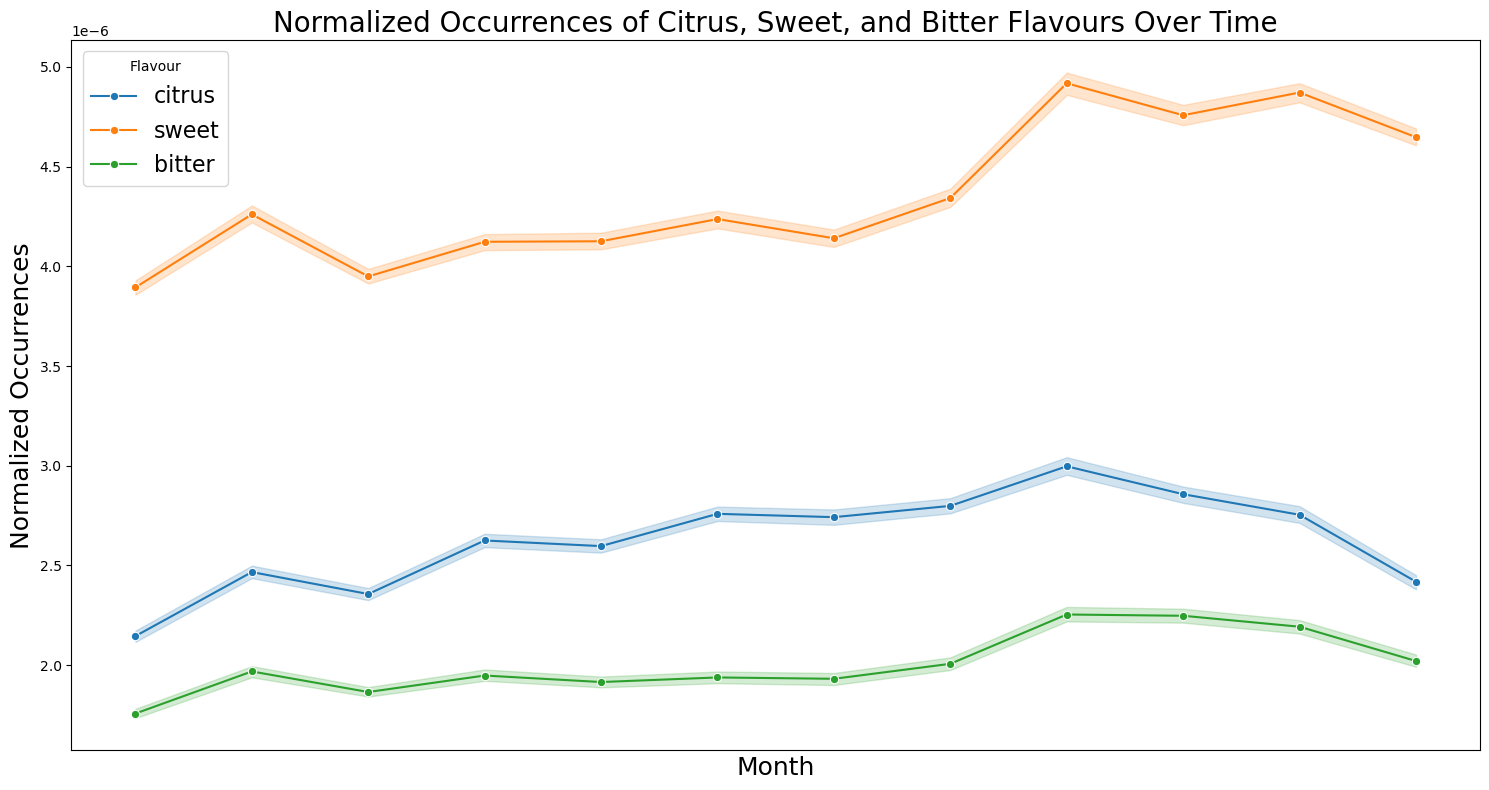

In [ ]:
flavours_review = sem_ana.analyse_flavours(clean_reviews)

We can see that have big augmentation of Sweet relative to Citrus and Bitter during the fall - winter which indicates a preference during this period

We want to see if some beers match visualy the tastes we are looking for.

Calculating total flavour mentions per style...


/var/folders/47/c40ytxbj0m7bhys1v6spbm_40000gn/T/ipykernel_22172/865676122.py:28: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





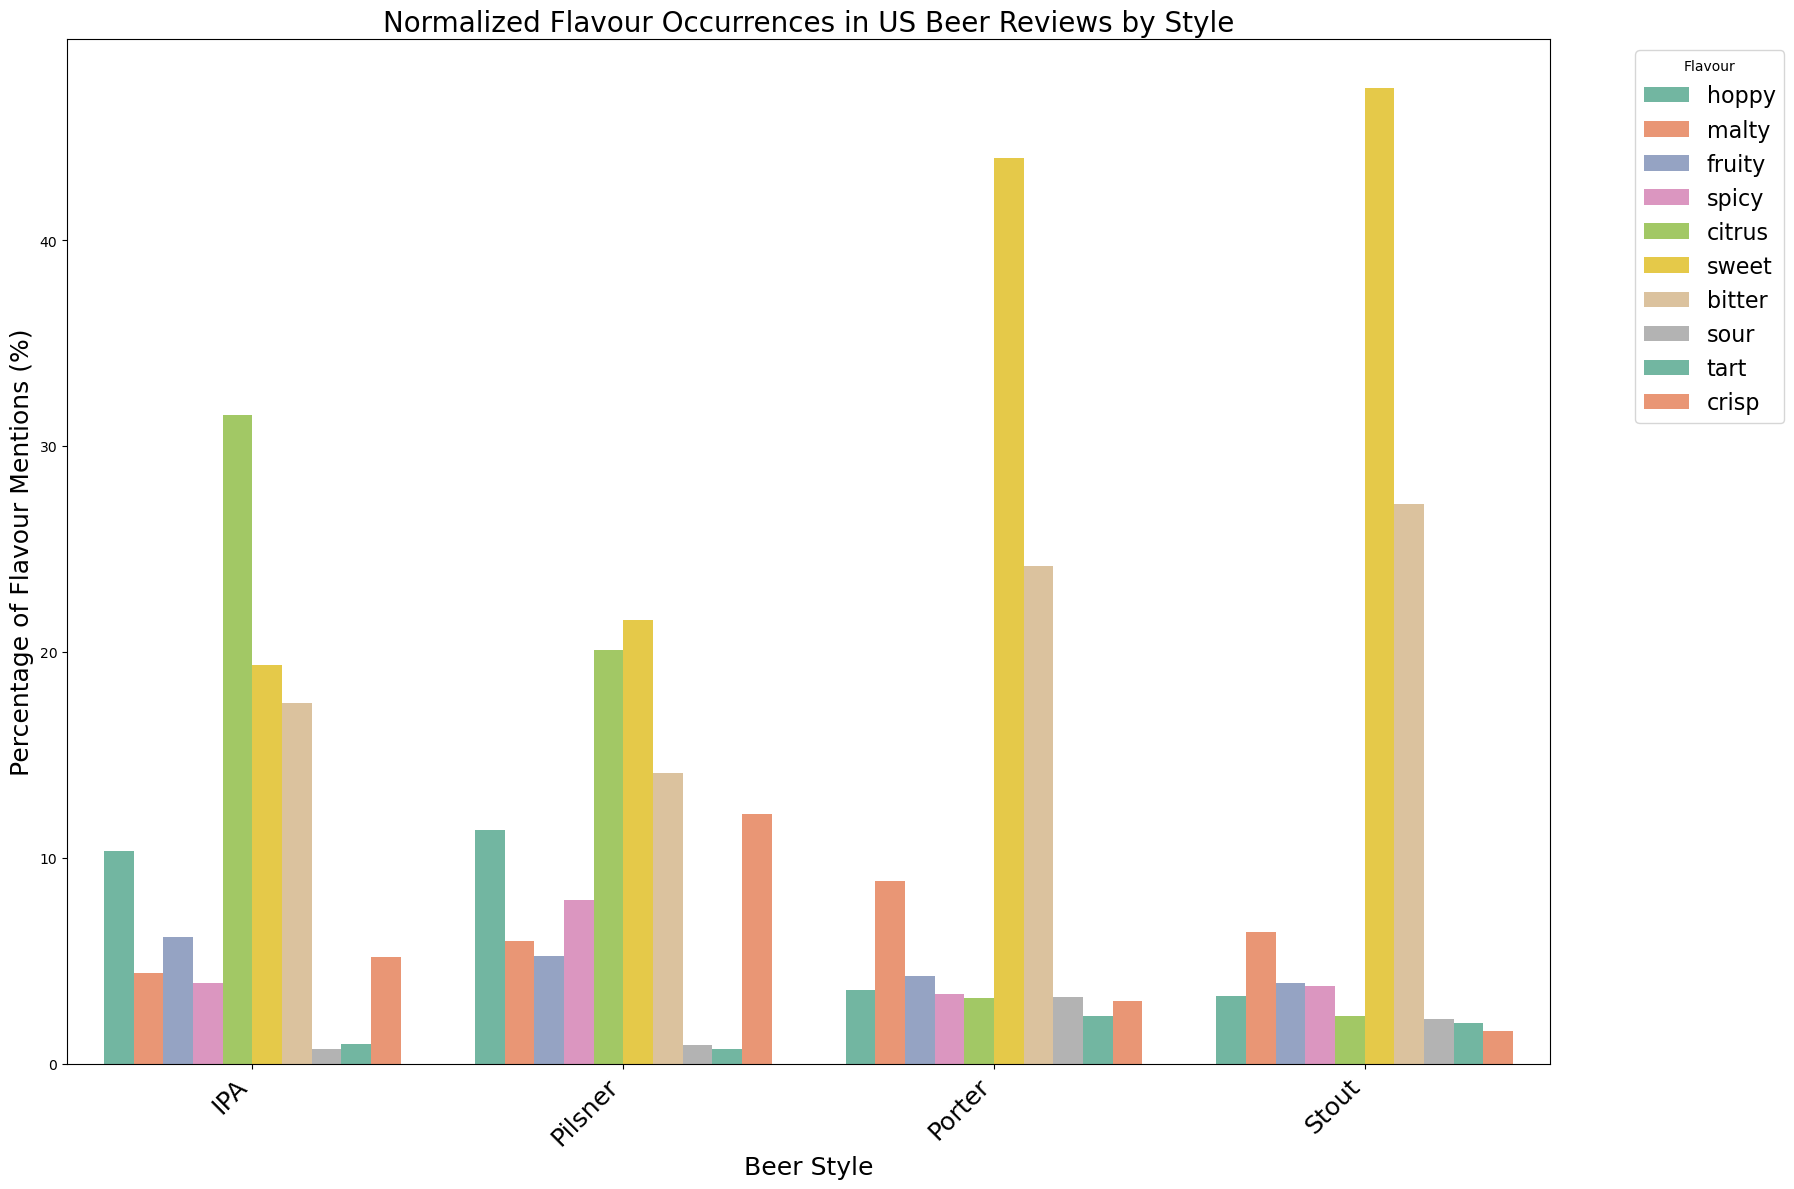

,style_simp,hoppy,malty,fruity,spicy,citrus,sweet,bitter,sour,tart,crisp
20,IPA,10.342108,4.383814,6.136500,3.902883,31.490116,19.378008,17.503078,0.722445,0.945422,5.195625
34,Pilsner,11.353798,5.972058,5.214482,7.959465,20.090516,21.536797,14.108619,0.914994,0.708383,12.140889
35,Porter,3.594846,8.872465,4.244836,3.373129,3.170362,43.998484,24.157665,3.248058,2.304340,3.035816
38,Stout,3.277824,6.378177,3.898689,3.796629,2.334904,47.377911,27.174585,2.190319,1.973158,1.597805


In [44]:
sem_ana.group_styles_by_flavours(flavours_review)

For example Stout would be a good winter beer contrary to wild beer. Thanks to our analysis we can provide a profile of perception of beer types, then map when wanted to seasonal preferences, thus directing production or marketing to seasonal trends.

### Semantic analysis by seasons

Now that we did a general semantic analysis on reviews, we will perform a semantic comparison on the season reviews, keeping only the highly rated ones. To do so, we categorize the reviews according to the season when they were written.

In [24]:
clean_positive_reviews = sem_ana.filter_positive_reviews(clean_reviews)

In [ ]:
# Categorize the reviews by season
winter_reviews = clean_positive_reviews[reviews['season'] == 'Winter']
spring_reviews = clean_positive_reviews[reviews['season'] == 'Spring']
summer_reviews = clean_positive_reviews[reviews['season'] == 'Summer']
autumn_reviews = clean_positive_reviews[reviews['season'] == 'Fall']

season_reviews = {
    "Winter": winter_reviews,
    "Spring": spring_reviews,
    "Summer": summer_reviews,
    "Autumn": autumn_reviews
}

On the BeerAdvocate website, they provide detailed guidance on rating beers, offering examples of adjectives for each characteristic (aroma, palate, mouthfeel, and taste), and grouping them into categories. For instance, in the case of aroma, adjectives like “sweet,” “roasty,” “smoky,” “toasty,” “nutty,” and “chocolate” are grouped under the category “Malt.” Drawing inspiration from their approach, we similarly grouped various adjectives into categories for all four characteristics. 

In [26]:
aroma_groups, palate_groups, mouthfeel_groups, taste_groups = categ.get_groups()

##### Aroma preferences

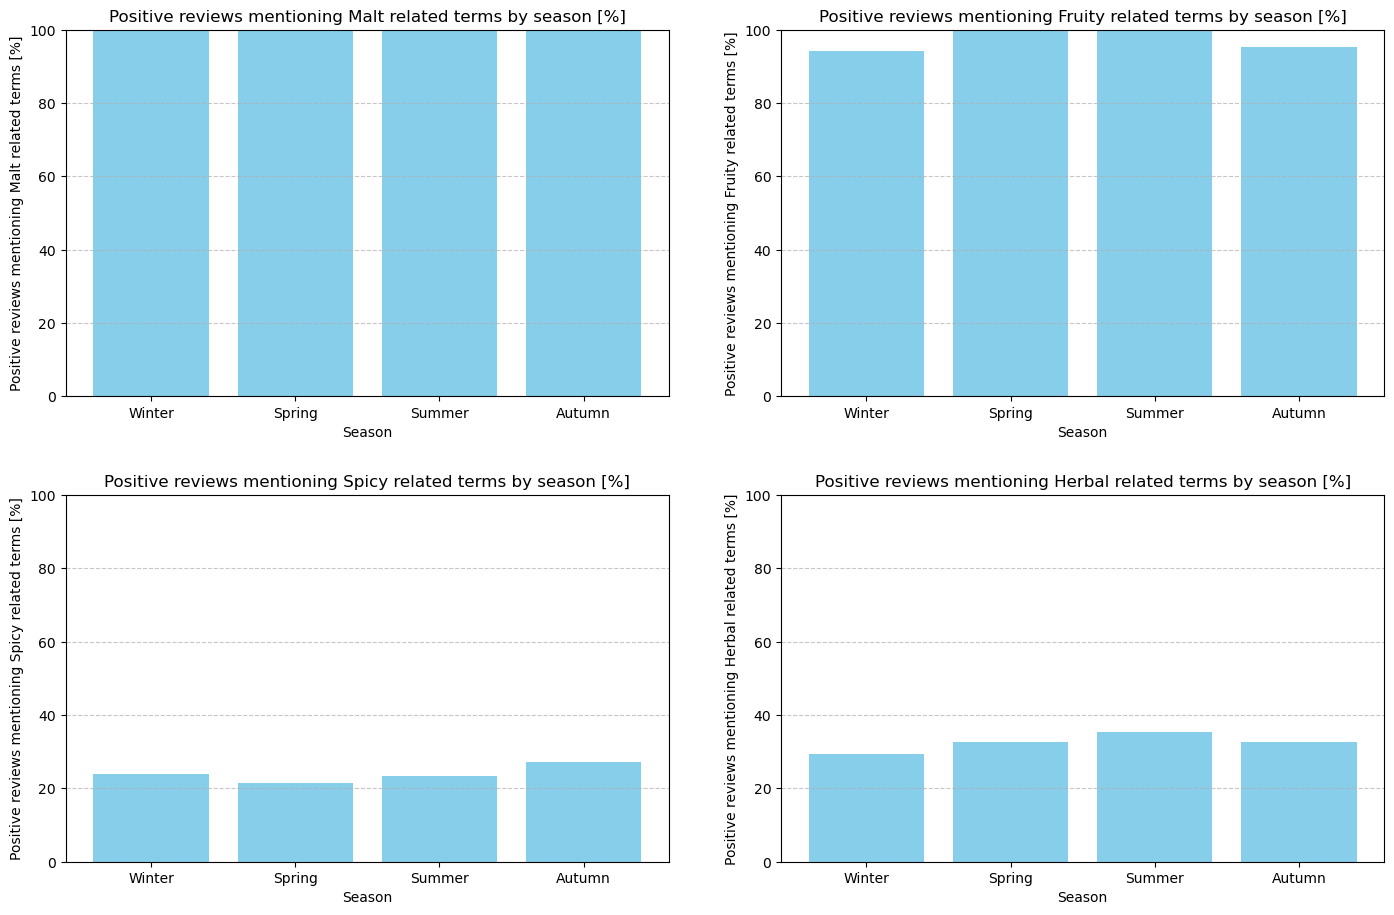

In [27]:
sem_ana.analyze_and_visualize_group_occurrences(aroma_groups, season_reviews)

Concerning **aroma preferences**, we can see a higher number of positive reviews mentioning fruit and herbal aromas during summer. On the contrary, spicyness is more represented in positive autumn reviews.

##### Mouthfeel preferences

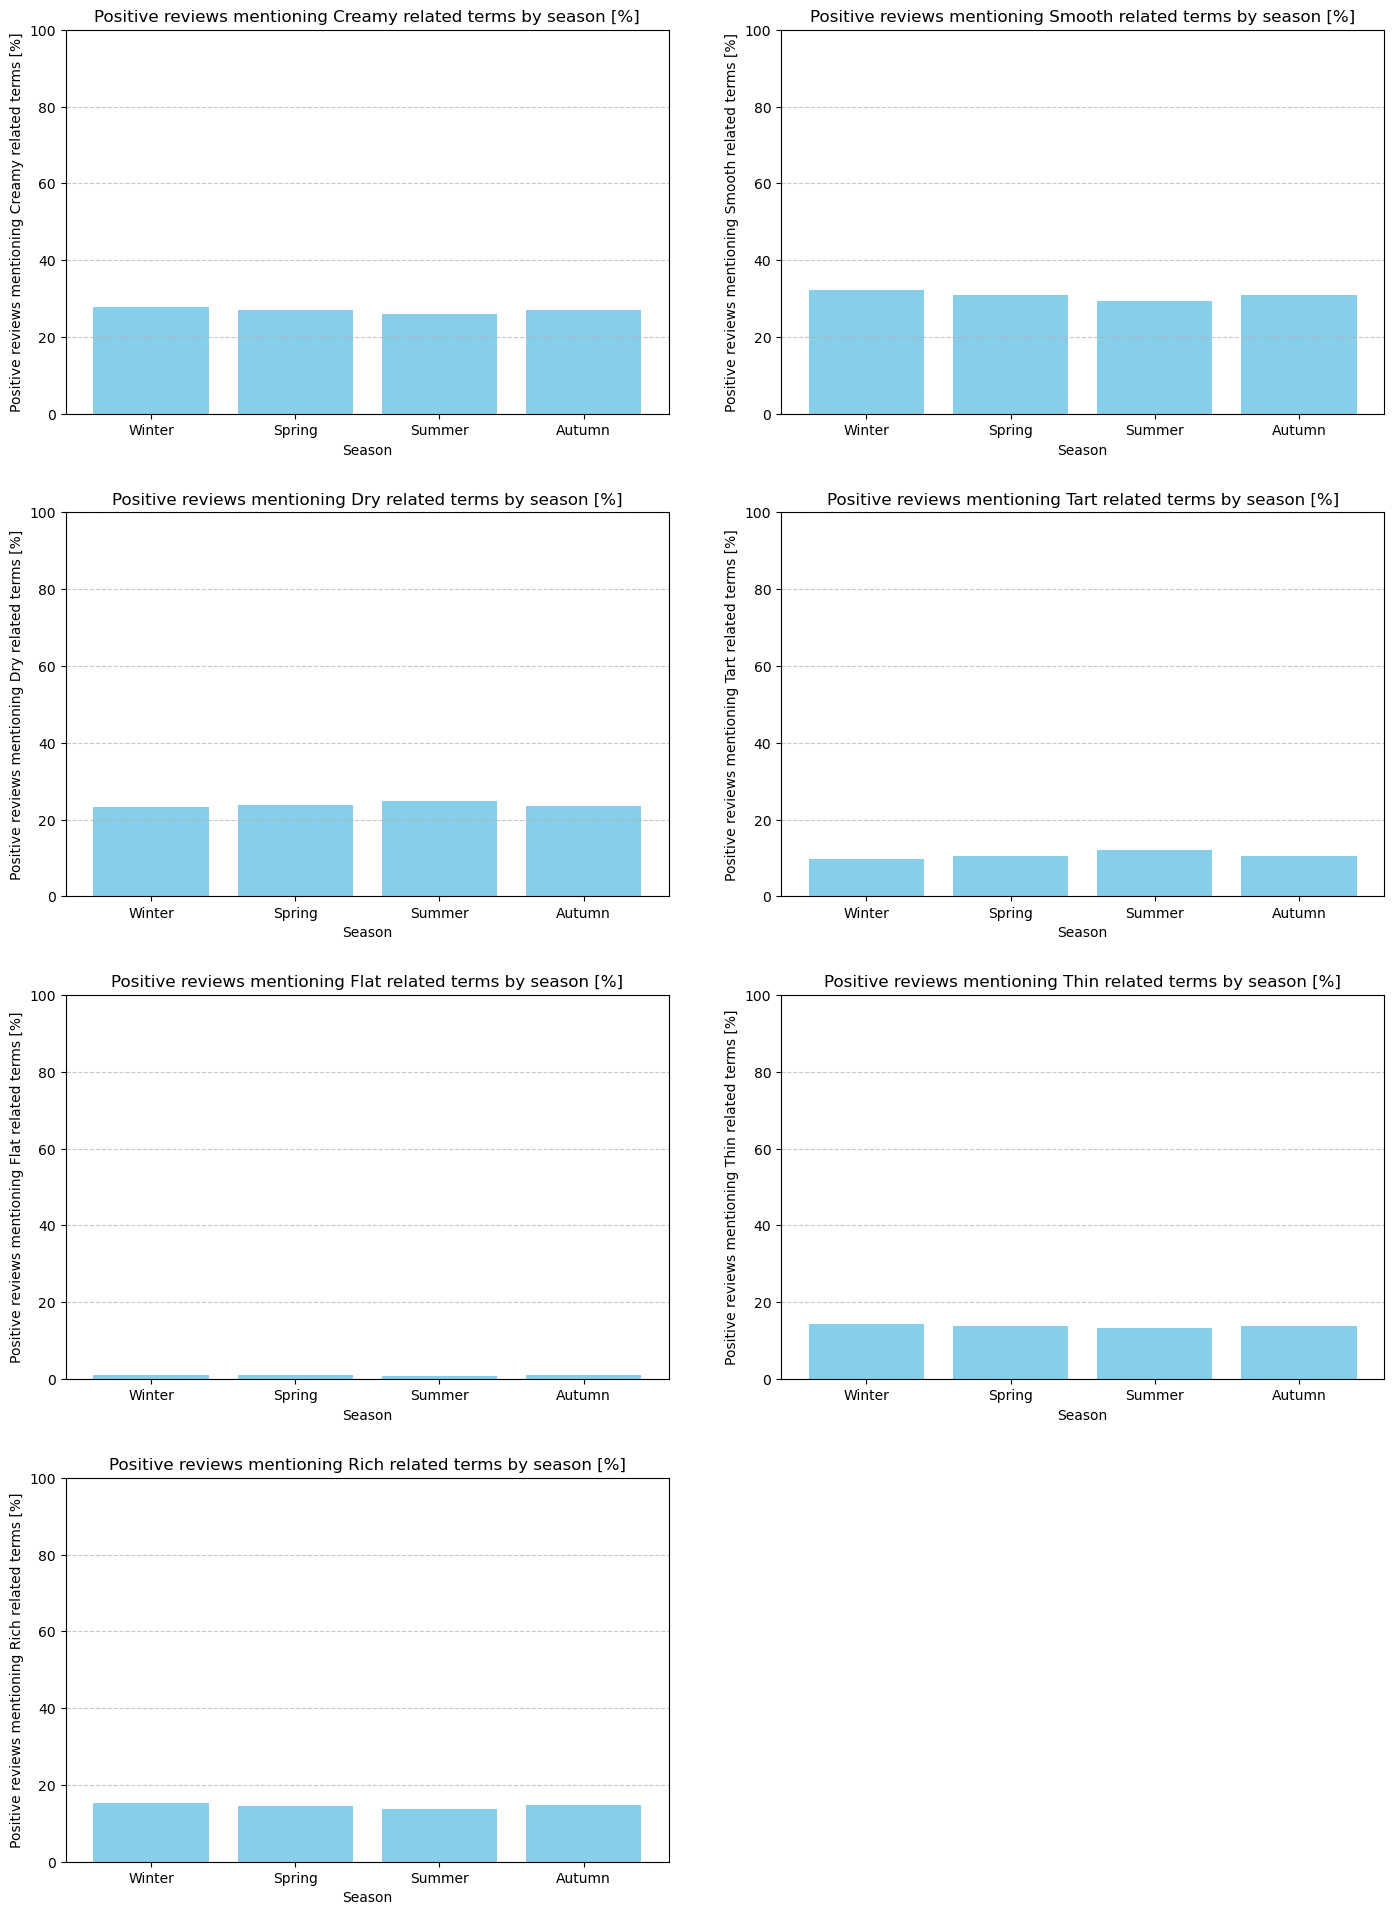

In [28]:
sem_ana.analyze_and_visualize_group_occurrences(mouthfeel_groups, season_reviews)

Concerning **Mouthfeel preferences**, we can't see a striking difference among seasons. However, we can wee a slight difference for "rich" related terms, that are less represented in positive summer reviews. On the side, "tart" related reviews are a bit more represented during summer.

##### Palate preferences

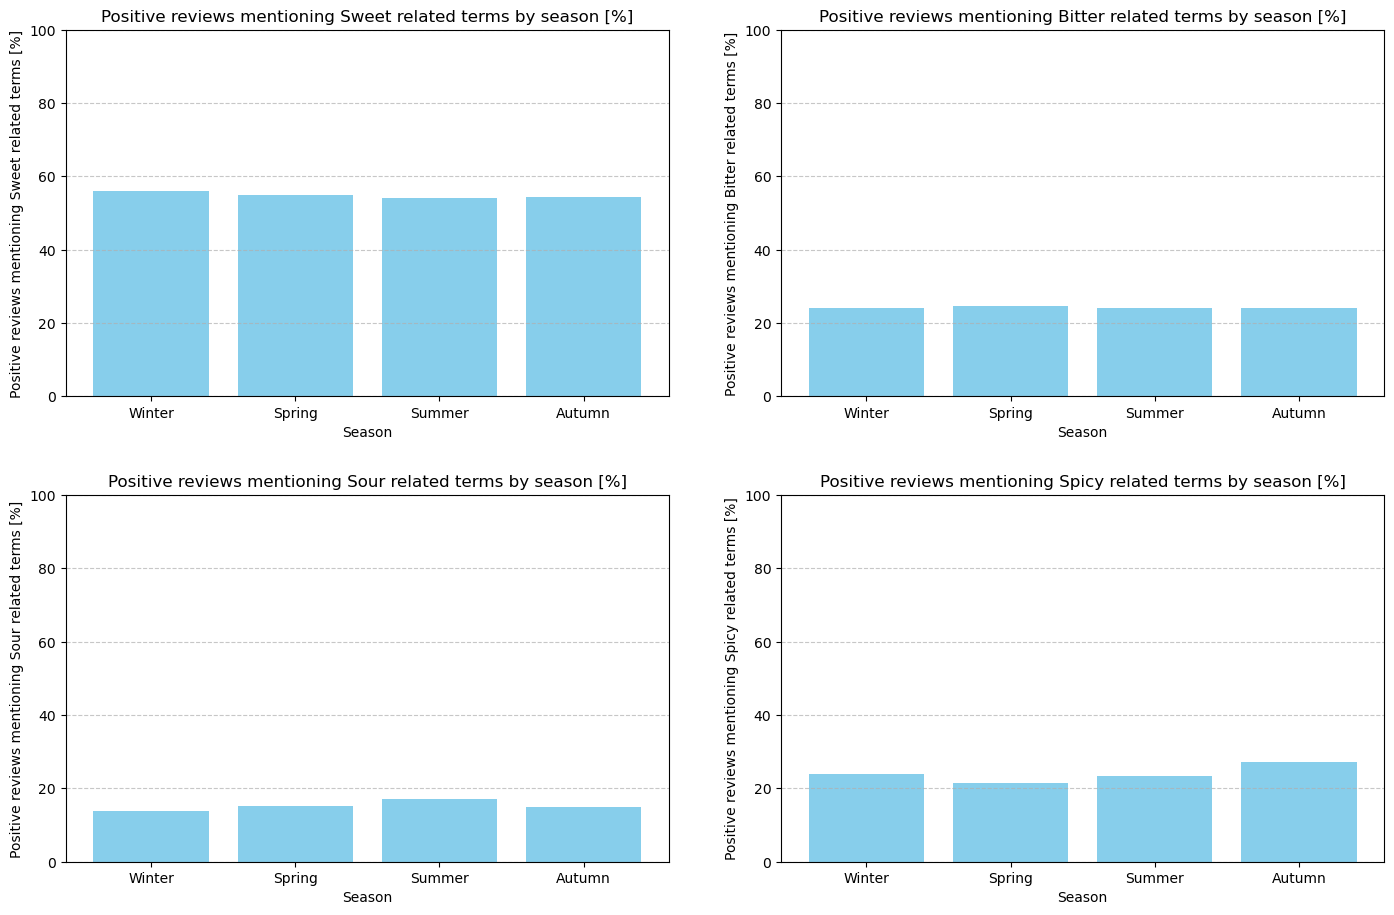

In [29]:
sem_ana.analyze_and_visualize_group_occurrences(palate_groups, season_reviews)

For **palate related words**, we can deduce that spicyness is more represented in positive autumn reviews, whereas "sour" related terms are more represented during summer.

#### Wordcloud by seasons

In [30]:
aroma_words_list = []
for group in aroma_groups.values():
    aroma_words_list.extend(group)

palate_words_list = []
for group in palate_groups.values():
    palate_words_list.extend(group)

mouthfeel_words_list = []
for group in mouthfeel_groups.values():
    mouthfeel_words_list.extend(group)

taste_words_list = []
for group in taste_groups.values():
    taste_words_list.extend(group)

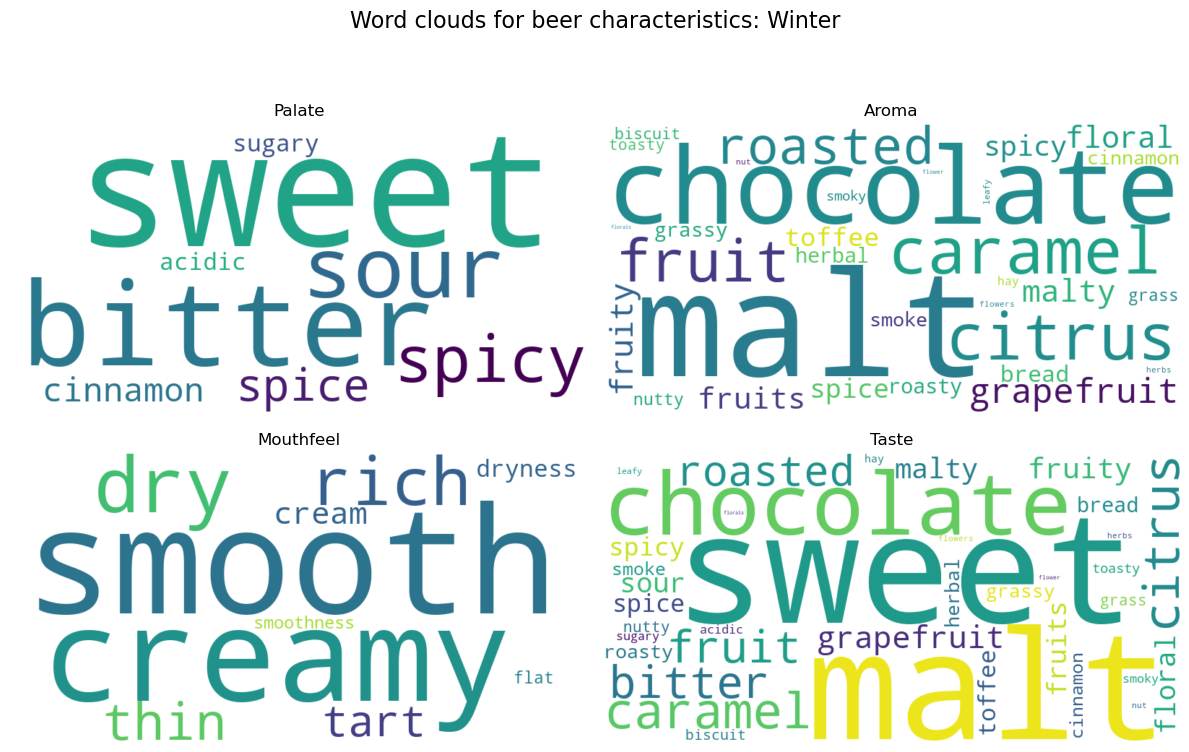

In [31]:
sem_ana.generate_season_wordclouds("Winter", winter_reviews, aroma_words_list, palate_words_list, mouthfeel_words_list, taste_words_list)

During Winter, we can see that people tend to prefer aromas that are rich, full in flavor, like "roasted", "caramel", "chocolate" aromas. We see the same trend for the palate, with a high occurrence of those same words. Moreover, people apparently prefer a "smooth", "creamy" and "rich" mouthfeel. This is also consistent with the taste preferences, with a high occurrence of the words "sweet", "chocolate".

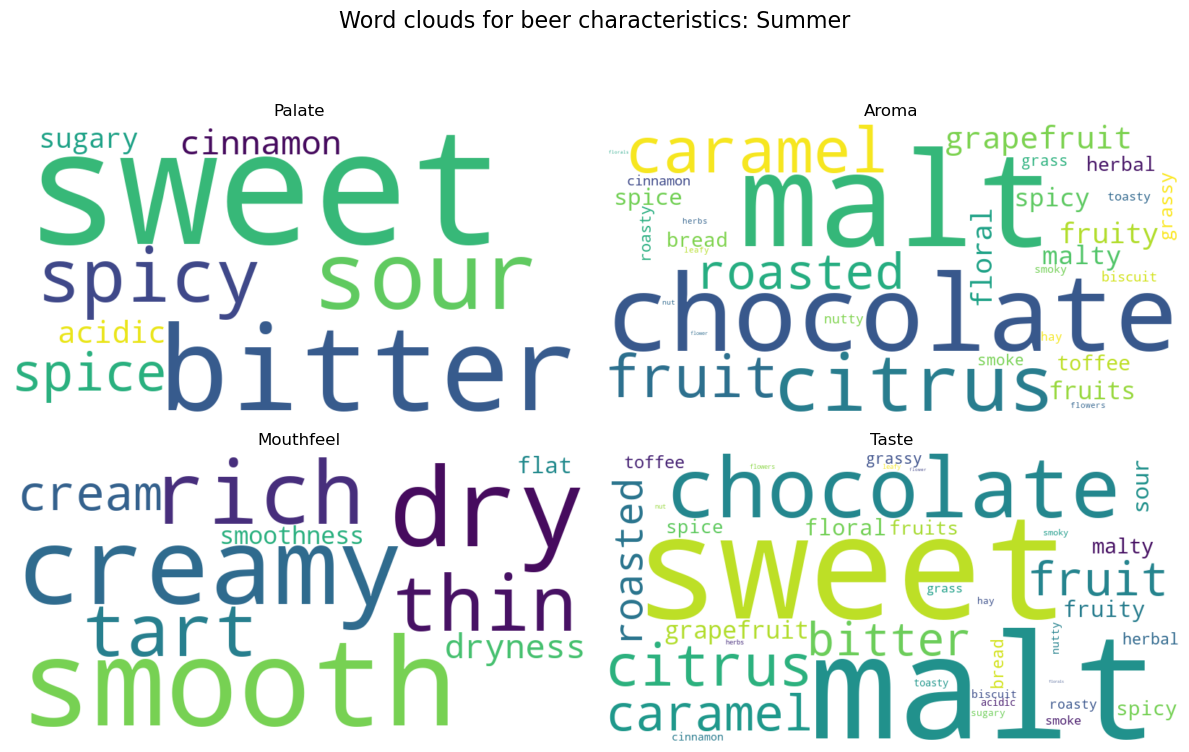

In [32]:
sem_ana.generate_season_wordclouds("Summer", summer_reviews, aroma_words_list, palate_words_list, mouthfeel_words_list, taste_words_list)

In summer, we can see there is a preference for light aromas, with a variety of words like "grapefruit", "citrus", "fruit", "fruity", "herbal", etc. Moreover, the word "bitter" is overrepresented for the palate category, compared to colder seasons.  Additionally, consumers seem to specifically like a "dry" mouthfeel, which is also an interesting result compared to the other seasons. Finally, concerning the taste criteria, we have opposing results, with high occurrence of words "sweet" and"citrus".

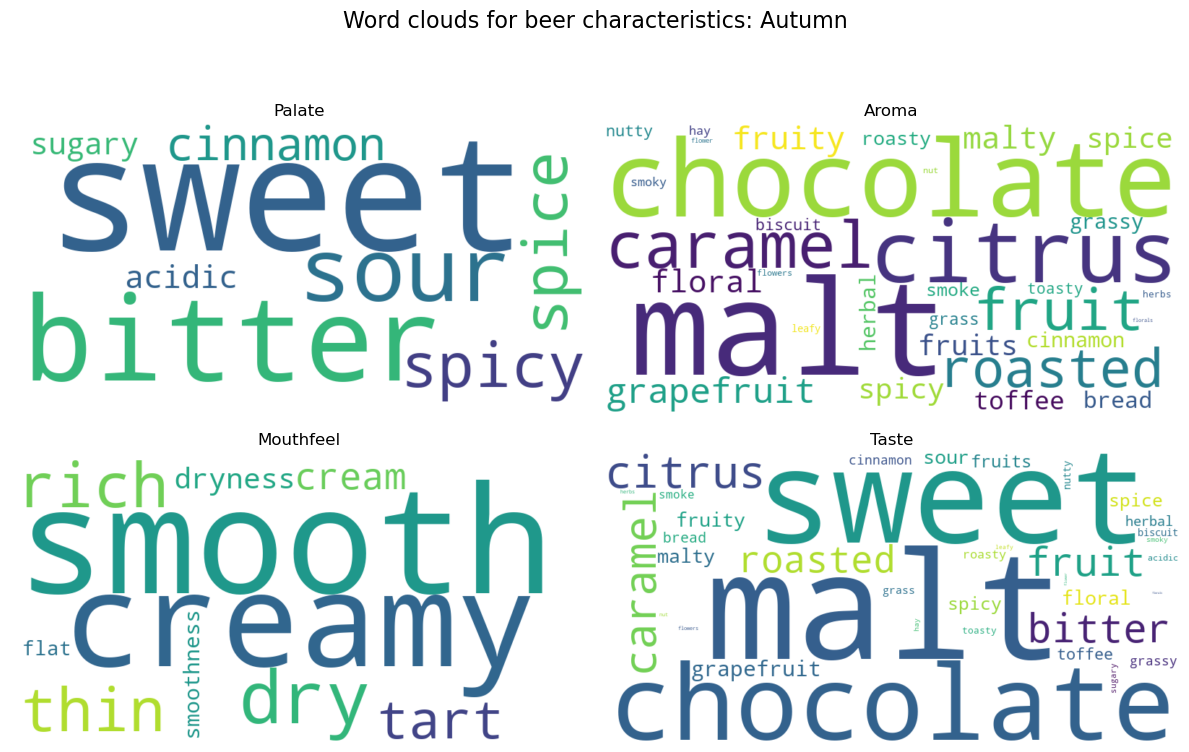

In [33]:
sem_ana.generate_season_wordclouds("Autumn", autumn_reviews, aroma_words_list, palate_words_list, mouthfeel_words_list, taste_words_list)

For Autumn, we can see a clear preference for full-bodied aromas, like "chocolate", "caramel", exactly like winter. Moreover, we can see an interesting change for the palate criteria, with a high occurrence of the word "spicy" and "sweet", which is relevant with the taste preferences. Finally, people also prefer a "smooth" and "creamy" mouthfeel during this time period, which is also similar for winter reviews.

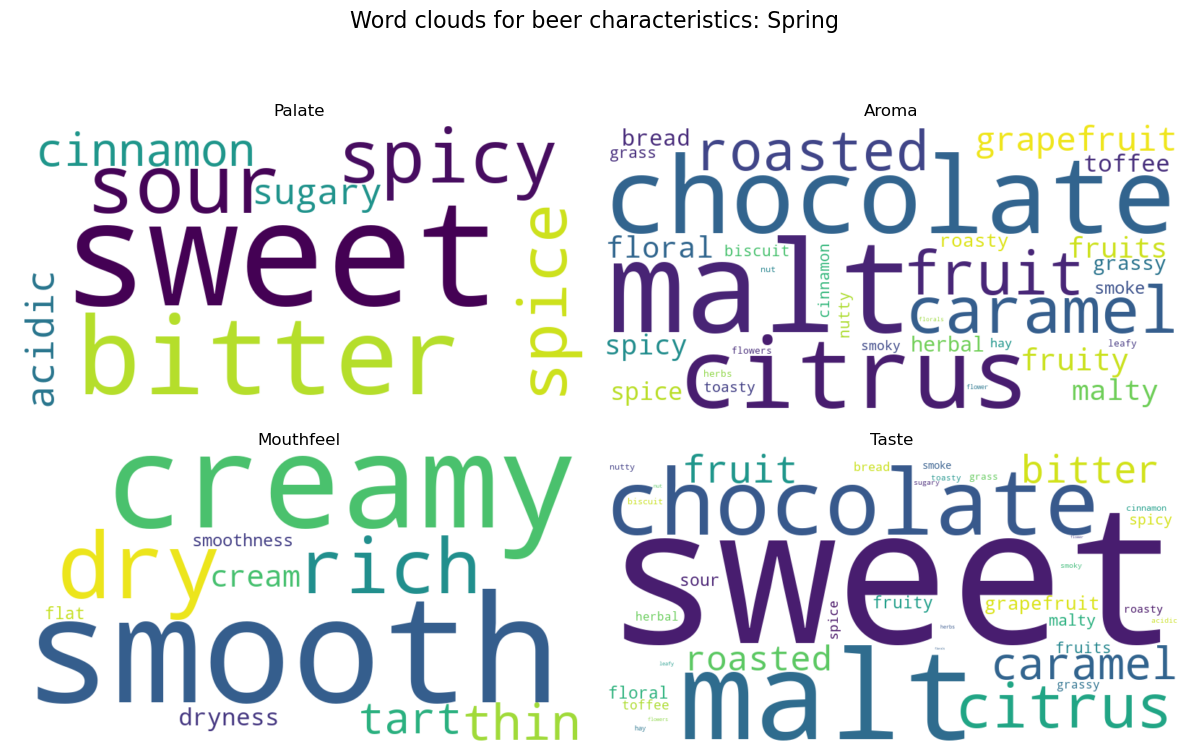

In [34]:
sem_ana.generate_season_wordclouds("Spring", spring_reviews, aroma_words_list, palate_words_list, mouthfeel_words_list, taste_words_list)

During Spring season, there is a clear preference for full-bodied aromas like "chocolate", "caramel". We also have a lot of fruit word occurrences, like "citrus", "grapefruit", fruit", etc. Moreover, we can see a clear difference on the palate level, as people seem to specifically appreciate "bitter" and "sour" palates.
Additionally, consumers seem to like a "creamy" and "smooth" mouthfeel, which stays quite common across the seasons.
Finally, "sweet" tastes are more favored during this time period.